In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\MEHEDI~1\AppData\Local\Temp/ipykernel_11688/1754229008.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


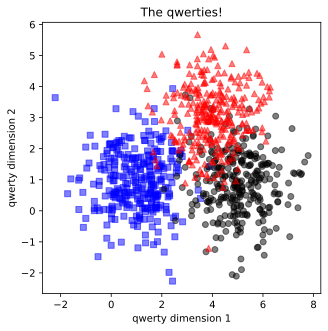

In [3]:
nPerClust = 300
blur = 1

A = [1,1]
B = [5,1]
C = [4,3]

a = [ A[0]+np.random.randn(nPerClust)*blur,A[1]+np.random.randn(nPerClust)*blur]
b = [ B[0]+np.random.randn(nPerClust)*blur,B[1]+np.random.randn(nPerClust)*blur]
c = [ C[0]+np.random.randn(nPerClust)*blur,C[1]+np.random.randn(nPerClust)*blur]

data_np = np.hstack((a,b,c)).T
labels_np = np.hstack((np.zeros((nPerClust)),
                     np.ones((nPerClust)),
                     1+np.ones((nPerClust))))

data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long()

fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [4]:
train_data,test_data,train_labels,test_labels = train_test_split(data,labels,test_size=.2)

train_dataset = TensorDataset(train_data,train_labels)
test_dataset = TensorDataset(test_data,test_labels)

batchsize = 16
train_loader = DataLoader(train_dataset,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader = DataLoader(test_dataset,batch_size=test_dataset.tensors[0].shape[0])


In [ ]:
def createTheQwertyNet(initialLR):
    
    class qwertyNet(nn.Module):
        
        def __init__(self):
            super().__init__()
            
            self.input = nn.Linear(2,8)
            self.fc1 = nn.Linear(8,8)
            self.output = nn.Linear(8,3)
            
        def forward(self,x):
            
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            return self.output(x)
        
    net = qwertyNet()
    lossfun = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(),lr=initialLR)
    stepsize = batchsize*len(train_loader)
    schedular = torch.optim.lr_scheduler.stepLR(optimizer)
            
        
                
                